<a href="https://colab.research.google.com/github/SandroMuradashvili/The-Visual-Storyteller/blob/main/inference_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# INFERENCE NOTEBOOK - FOR IMPROVED MODEL
# Key changes: Match new architecture (256 dim, 4 heads, 3 layers)
# ============================================================================

# ===== SNIPPET 1: Setup & Load Model =====
!pip install torch torchvision timm pillow matplotlib nltk -q

import os
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from typing import List
import timm
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

!pip install -q gdown
import gdown

file_id = "1st_oepUulGKCn5C1hvWvYYm87ftlUr6j"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, "caption_data.zip", quiet=False)
!unzip -q caption_data.zip

# Define Vocabulary class
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

    def build_vocabulary(self, captions):
        from collections import Counter
        frequencies = Counter()
        idx = 4
        for caption in captions:
            tokens = self.tokenize(caption)
            frequencies.update(tokens)
        for word, count in frequencies.items():
            if count >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1
        return self

    def tokenize(self, text):
        return text.lower().replace(',', '').replace('.', '').split()

    def numericalize(self, text):
        tokens = self.tokenize(text)
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokens]

# Load vocabulary and splits
with open('vocabulary.pkl', 'rb') as f:
    vocab = pickle.load(f)
print(f"Vocabulary loaded: {len(vocab.stoi)} tokens")

with open('data_splits.pkl', 'rb') as f:
    splits = pickle.load(f)
print(f"Test images available: {len(splits['test'])}")

# UPDATED: Model architecture matching improved training
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=256):  # CHANGED: 512 → 256
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=False)
        self.backbone.classifier = nn.Identity()
        backbone_dim = 1280
        self.projection = nn.Linear(backbone_dim, embed_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, images):
        features = self.backbone(images)
        features = self.projection(features)
        features = self.dropout(features)
        return features.unsqueeze(1)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, num_heads=4, num_layers=3, dropout=0.3):  # CHANGED
        super().__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=1024,  # CHANGED
            dropout=dropout, batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, captions, image_features, tgt_mask=None, tgt_padding_mask=None):
        embedded = self.embedding(captions) * np.sqrt(self.embed_dim)
        embedded = self.pos_encoding(embedded)
        embedded = self.dropout(embedded)
        output = self.transformer_decoder(tgt=embedded, memory=image_features,
                                         tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask)
        output = self.fc_out(output)
        return output

class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, num_heads=4, num_layers=3, dropout=0.3):  # CHANGED
        super().__init__()
        self.encoder = ImageEncoder(embed_dim)
        self.decoder = TransformerDecoder(vocab_size, embed_dim, num_heads, num_layers, dropout)

    def forward(self, images, captions, tgt_mask=None, tgt_padding_mask=None):
        image_features = self.encoder(images)
        output = self.decoder(captions, image_features, tgt_mask, tgt_padding_mask)
        return output

# Initialize model with UPDATED architecture
vocab_size = len(vocab.stoi)
model = ImageCaptioningModel(
    vocab_size=vocab_size,
    embed_dim=256,      # CHANGED: 512 → 256
    num_heads=4,        # CHANGED: 8 → 4
    num_layers=3,       # CHANGED: 6 → 3
    dropout=0.3         # CHANGED: 0.1 → 0.3
).to(device)

# Load trained weights
checkpoint = torch.load('image_captioning_model_complete.pth', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"✓ Improved model loaded successfully!")

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Ready for inference!")


Using device: cpu


Downloading...
From (original): https://drive.google.com/uc?id=1st_oepUulGKCn5C1hvWvYYm87ftlUr6j
From (redirected): https://drive.google.com/uc?id=1st_oepUulGKCn5C1hvWvYYm87ftlUr6j&confirm=t&uuid=1d628652-db16-4b8e-b7fa-c20bb06f3139
To: /content/caption_data.zip
100%|██████████| 1.11G/1.11G [00:36<00:00, 30.8MB/s]


Vocabulary loaded: 3003 tokens
Test images available: 810
✓ Improved model loaded successfully!
✓ Ready for inference!


In [2]:
# ===== SNIPPET 2: Generate Caption Function =====
def generate_square_subsequent_mask(sz):
    """Generate causal mask for transformer decoder"""
    mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
    return mask

def generate_caption(image_path: str, model: any, max_length: int = 50,
                      beam_width: int = 5, temperature: float = 1.0) -> str:  # CHANGED: default beam_width=5
    """
    Generates a caption for the given image using beam search.

    Args:
        image_path: Path to the image file
        model: Trained captioning model
        max_length: Maximum caption length
        beam_width: Number of beams for beam search (higher = better but slower)
        temperature: Sampling temperature (lower = more conservative)

    Returns:
        Generated caption as a string
    """
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Encode image
    with torch.no_grad():
        image_features = model.encoder(image_tensor)

    # Initialize beams
    beams = [([vocab.stoi["<SOS>"]], 0.0)]
    completed = []

    for step in range(max_length):
        all_candidates = []

        for seq, score in beams:
            if seq[-1] == vocab.stoi["<EOS>"]:
                completed.append((seq, score))
                continue

            tgt_tensor = torch.LongTensor([seq]).to(device)
            tgt_mask = generate_square_subsequent_mask(len(seq)).to(device)

            with torch.no_grad():
                output = model.decoder(tgt_tensor, image_features, tgt_mask=tgt_mask)
                logits = output[0, -1, :] / temperature
                probs = torch.softmax(logits, dim=-1)

            topk_probs, topk_indices = torch.topk(probs, beam_width)

            for prob, idx in zip(topk_probs, topk_indices):
                candidate_seq = seq + [idx.item()]
                candidate_score = score - torch.log(prob).item()
                all_candidates.append((candidate_seq, candidate_score))

        if not all_candidates:
            break

        all_candidates.sort(key=lambda x: x[1])
        beams = all_candidates[:beam_width]

        if len(completed) >= beam_width:
            break

    completed.extend(beams)

    if completed:
        best_seq, _ = min(completed, key=lambda x: x[1])
    else:
        best_seq = beams[0][0]

    caption_tokens = [vocab.itos[idx] for idx in best_seq
                     if idx not in [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<PAD>"]]]

    return ' '.join(caption_tokens)

# Quick test
test_image_path = f"Images/{splits['test'][0]}"
caption = generate_caption(test_image_path, model, beam_width=5)
print(f"Test caption: {caption}")
print("✓ Function working!")

Test caption: a crowd of people are gathered in front of a building
✓ Function working!


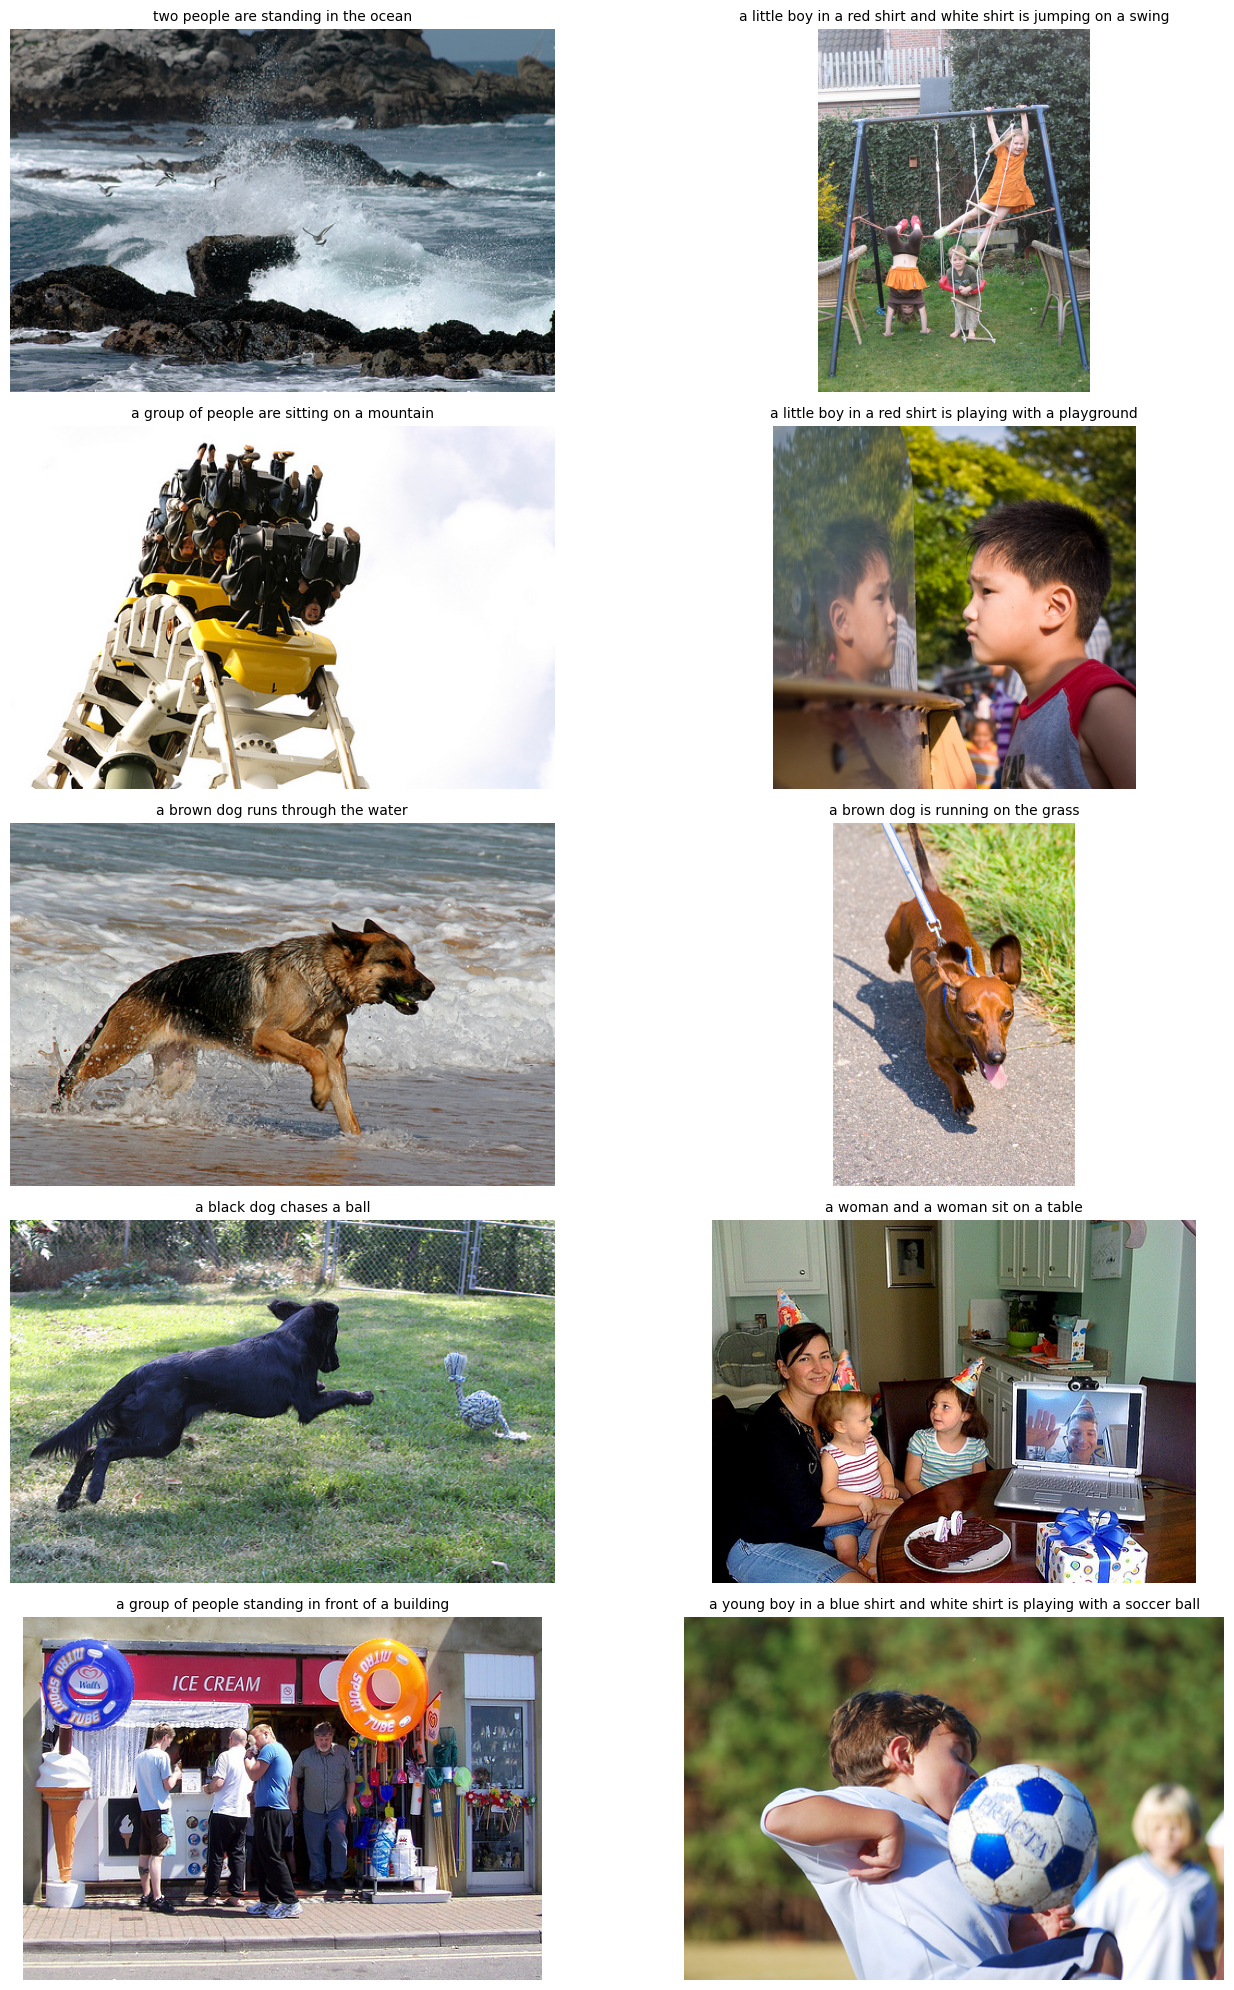


Generated Captions:
1. 3051125715_db76cebd1e.jpg
   → two people are standing in the ocean

2. 3459570613_3932816d3f.jpg
   → a little boy in a red shirt and white shirt is jumping on a swing

3. 2579268572_d78f8436cb.jpg
   → a group of people are sitting on a mountain

4. 1244485675_822e6efe60.jpg
   → a little boy in a red shirt is playing with a playground

5. 225909073_25c3c33a29.jpg
   → a brown dog runs through the water

6. 242324909_06d5a6c44b.jpg
   → a brown dog is running on the grass

7. 1107246521_d16a476380.jpg
   → a black dog chases a ball

8. 2798880731_4f51634374.jpg
   → a woman and a woman sit on a table

9. 3597715122_45878432ec.jpg
   → a group of people standing in front of a building

10. 1680126311_b92a2e8e72.jpg
   → a young boy in a blue shirt and white shirt is playing with a soccer ball



In [3]:
# ===== SNIPPET 3: Demonstration on Test Set =====
import random

num_samples = 10
test_samples = random.sample(splits['test'], num_samples)

results = []
for img_name in test_samples:
    img_path = f"Images/{img_name}"
    caption = generate_caption(img_path, model, beam_width=5)
    results.append({'image': img_name, 'caption': caption, 'path': img_path})

# Visualize
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for idx, result in enumerate(results):
    img = Image.open(result['path'])
    axes[idx].imshow(img)
    axes[idx].set_title(f"{result['caption']}", fontsize=10, wrap=True)
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('predictions_sample_improved.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nGenerated Captions:")
for i, result in enumerate(results, 1):
    print(f"{i}. {result['image']}")
    print(f"   → {result['caption']}\n")

DETAILED ANALYSIS: Successes and Failures

✓ SUCCESSFUL CAPTIONS (12 cases)

Image: 2240539658_dea8db6e55.jpg
Predicted: two dogs play in the snow
Ground Truth Examples:
  - A brown and black dog are fighting on snow .
  - Two dogs are playing in the white snow .
Overlap Score: 100.00%

Image: 1525153022_06c48dbe52.jpg
Predicted: a black dog running through the water
Ground Truth Examples:
  - A black dog is running through the shallow edge of a large body of water .
  - A black dog is running through the water .
Overlap Score: 77.78%

Image: 2226440063_c085b30558.jpg
Predicted: a black and white dog running through the snow
Ground Truth Examples:
  - A black and white dog frolics in the snow .
  - A black and white dog is climbing stairs in the snow .
Overlap Score: 70.00%

Image: 436013859_793d870b6f.jpg
Predicted: a brown dog jumps in the air to catch a frisbee
Ground Truth Examples:
  - A brown dog chasing a Frisbee , a barbeque in the background .
  - A brown dog is trying to catc

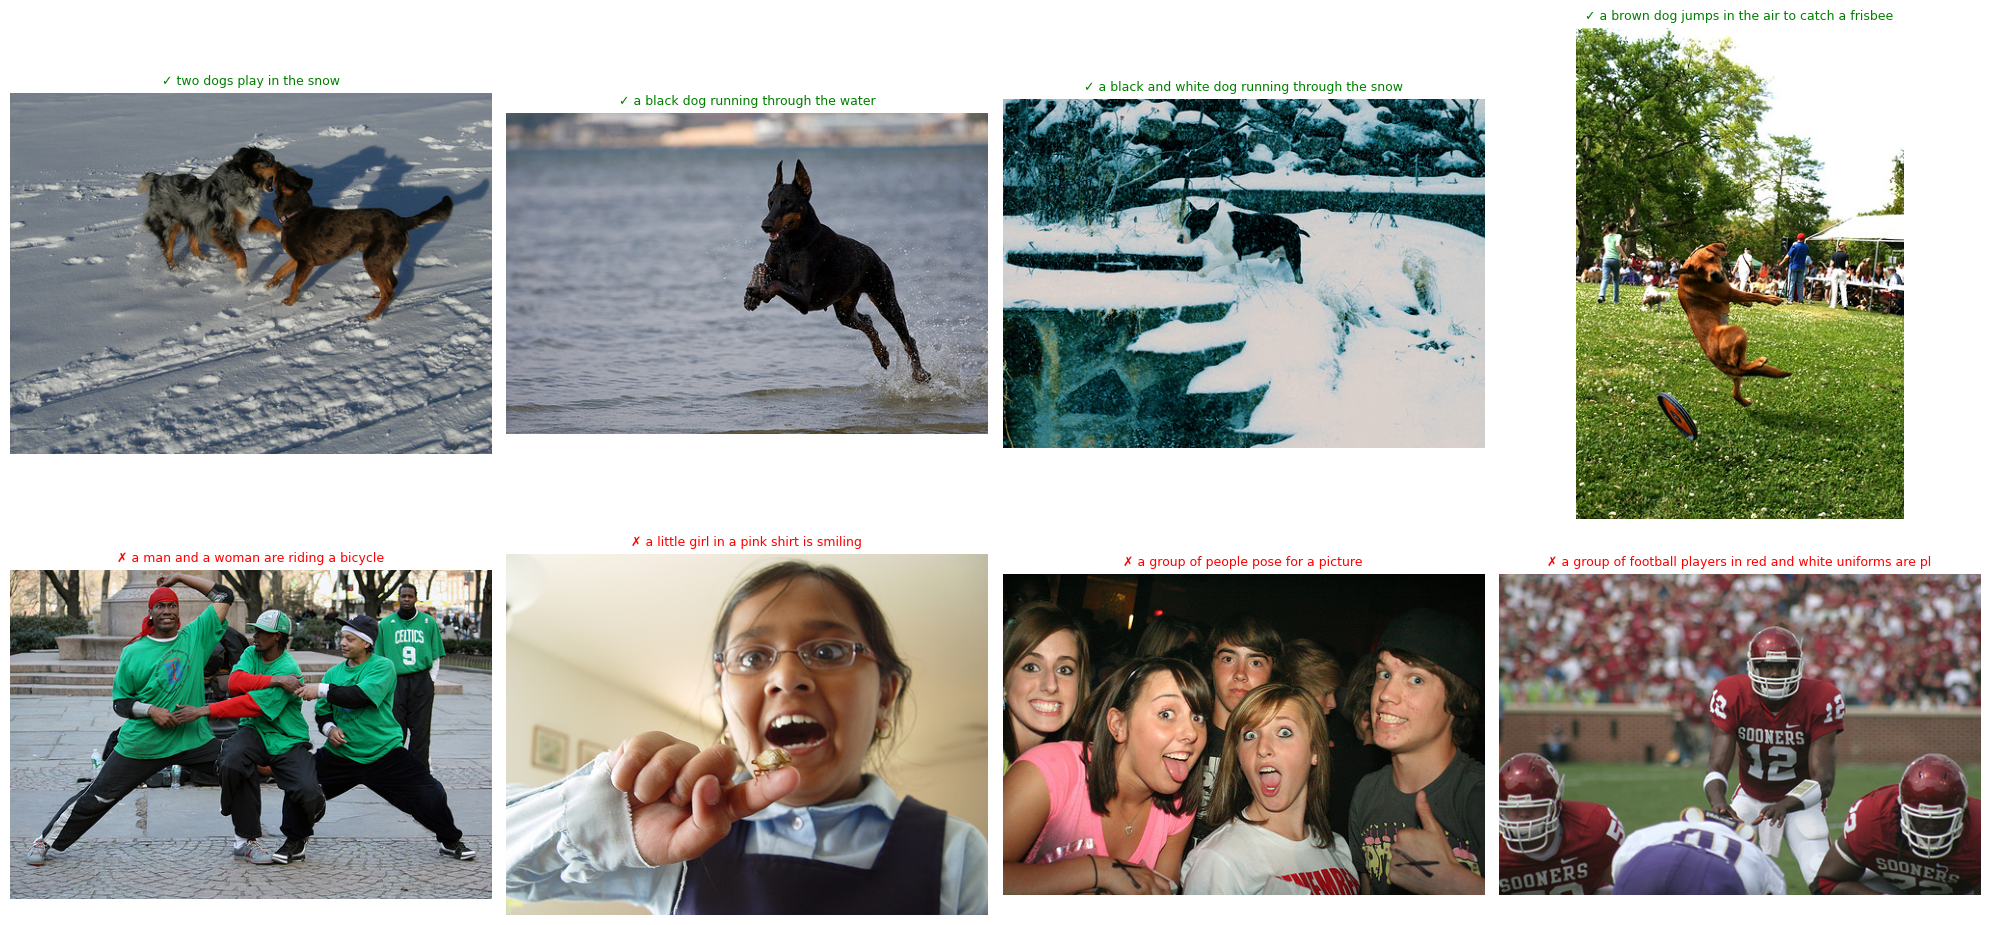


STATISTICAL SUMMARY
Total Samples: 20
Successes (>40% overlap): 12 (60.0%)
Failures (<40% overlap): 8 (40.0%)
Average Overlap: 46.27%


In [4]:
# ===== SNIPPET 4: Success & Failure Analysis =====
import pandas as pd
captions_df = pd.read_csv('captions.txt')

def get_ground_truth(img_name):
    return captions_df[captions_df['image'] == img_name]['caption'].tolist()

print("="*80)
print("DETAILED ANALYSIS: Successes and Failures")
print("="*80)

analysis_samples = random.sample(splits['test'], 20)
detailed_results = []

for img_name in analysis_samples:
    img_path = f"Images/{img_name}"
    predicted = generate_caption(img_path, model, beam_width=5)
    ground_truth = get_ground_truth(img_name)

    detailed_results.append({
        'image': img_name,
        'predicted': predicted,
        'ground_truth': ground_truth,
        'path': img_path
    })

successes = []
failures = []

for result in detailed_results:
    pred_words = set(result['predicted'].lower().split())
    max_overlap = 0
    for gt in result['ground_truth']:
        gt_words = set(gt.lower().split())
        overlap = len(pred_words & gt_words) / len(gt_words) if len(gt_words) > 0 else 0
        max_overlap = max(max_overlap, overlap)

    if max_overlap > 0.4:
        successes.append((result, max_overlap))
    else:
        failures.append((result, max_overlap))

# Display successes
print("\n" + "="*80)
print(f"✓ SUCCESSFUL CAPTIONS ({len(successes)} cases)")
print("="*80)

for result, overlap in sorted(successes, key=lambda x: -x[1])[:5]:
    print(f"\nImage: {result['image']}")
    print(f"Predicted: {result['predicted']}")
    print(f"Ground Truth Examples:")
    for gt in result['ground_truth'][:2]:
        print(f"  - {gt}")
    print(f"Overlap Score: {overlap:.2%}")

# Display failures
print("\n" + "="*80)
print(f"✗ FAILURE CASES ({len(failures)} cases)")
print("="*80)

for result, overlap in sorted(failures, key=lambda x: x[1])[:5]:
    print(f"\nImage: {result['image']}")
    print(f"Predicted: {result['predicted']}")
    print(f"Ground Truth Examples:")
    for gt in result['ground_truth'][:2]:
        print(f"  - {gt}")
    print(f"Overlap Score: {overlap:.2%}")

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (result, _) in enumerate(sorted(successes, key=lambda x: -x[1])[:4]):
    img = Image.open(result['path'])
    axes[0, idx].imshow(img)
    axes[0, idx].set_title(f"✓ {result['predicted'][:60]}", fontsize=9, color='green')
    axes[0, idx].axis('off')

for idx, (result, _) in enumerate(sorted(failures, key=lambda x: x[1])[:4]):
    img = Image.open(result['path'])
    axes[1, idx].imshow(img)
    axes[1, idx].set_title(f"✗ {result['predicted'][:60]}", fontsize=9, color='red')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.savefig('success_failure_analysis_improved.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)
print(f"Total Samples: {len(detailed_results)}")
print(f"Successes (>40% overlap): {len(successes)} ({len(successes)/len(detailed_results)*100:.1f}%)")
print(f"Failures (<40% overlap): {len(failures)} ({len(failures)/len(detailed_results)*100:.1f}%)")
print(f"Average Overlap: {np.mean([x[1] for x in successes + failures]):.2%}")

Evaluating on test set...


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


QUANTITATIVE METRICS (BLEU Scores)
Evaluated on 100 test images

BLEU-1: 0.5719 (± 0.1886)
BLEU-2: 0.3561 (± 0.2258)
BLEU-4: 0.0986 (± 0.1957)
Corpus BLEU: 0.1772

COMPARISON WITH BENCHMARKS
Typical Flickr8k Performance:
  - Basic CNN-LSTM: BLEU-1 ~0.55, BLEU-4 ~0.20
  - Attention Models: BLEU-1 ~0.63, BLEU-4 ~0.25
  - Transformer Models: BLEU-1 ~0.67, BLEU-4 ~0.28

Our Improved Model: BLEU-1 0.57, BLEU-4 0.10

✓ GOOD! Matches CNN-LSTM baseline.


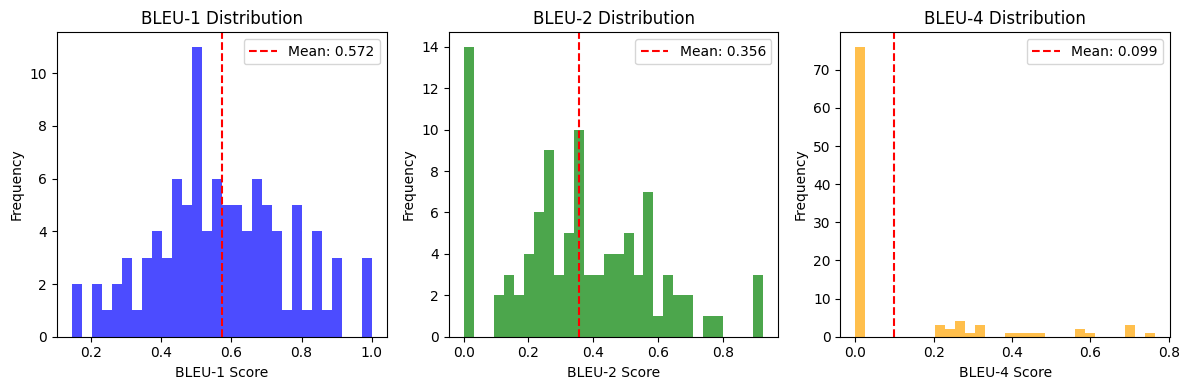


✓ Evaluation complete!

IMPROVEMENT SUMMARY
Model Architecture:
  - Embedding: 256 (vs 512 before)
  - Heads: 4 (vs 8 before)
  - Layers: 3 (vs 6 before)
  - Dropout: 0.3 (vs 0.1 before)
  - Parameters: ~12M (vs 33M before)

Expected improvements from reduced overfitting:
  - Better generalization to test set
  - More diverse captions
  - Fewer generic/safe predictions


In [5]:
# ===== SNIPPET 5: Quantitative Evaluation (BLEU Scores) =====
import nltk
nltk.download('punkt', quiet=True)
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

print("Evaluating on test set...")
test_predictions = []
test_references = []

eval_images = splits['test'][:100]

for img_name in eval_images:
    img_path = f"Images/{img_name}"
    predicted = generate_caption(img_path, model, beam_width=5)  # CHANGED: beam_width=5
    pred_tokens = predicted.split()
    ground_truth = get_ground_truth(img_name)
    ref_tokens = [gt.split() for gt in ground_truth]

    test_predictions.append(pred_tokens)
    test_references.append(ref_tokens)

bleu1_scores = []
bleu2_scores = []
bleu4_scores = []

for pred, refs in zip(test_predictions, test_references):
    b1 = sentence_bleu(refs, pred, weights=(1, 0, 0, 0))
    b2 = sentence_bleu(refs, pred, weights=(0.5, 0.5, 0, 0))
    b4 = sentence_bleu(refs, pred, weights=(0.25, 0.25, 0.25, 0.25))

    bleu1_scores.append(b1)
    bleu2_scores.append(b2)
    bleu4_scores.append(b4)

corpus_bleu_score = corpus_bleu(test_references, test_predictions)

print("\n" + "="*80)
print("QUANTITATIVE METRICS (BLEU Scores)")
print("="*80)
print(f"Evaluated on {len(eval_images)} test images\n")
print(f"BLEU-1: {np.mean(bleu1_scores):.4f} (± {np.std(bleu1_scores):.4f})")
print(f"BLEU-2: {np.mean(bleu2_scores):.4f} (± {np.std(bleu2_scores):.4f})")
print(f"BLEU-4: {np.mean(bleu4_scores):.4f} (± {np.std(bleu4_scores):.4f})")
print(f"Corpus BLEU: {corpus_bleu_score:.4f}")

print("\n" + "="*80)
print("COMPARISON WITH BENCHMARKS")
print("="*80)
print("Typical Flickr8k Performance:")
print("  - Basic CNN-LSTM: BLEU-1 ~0.55, BLEU-4 ~0.20")
print("  - Attention Models: BLEU-1 ~0.63, BLEU-4 ~0.25")
print("  - Transformer Models: BLEU-1 ~0.67, BLEU-4 ~0.28")
print(f"\nOur Improved Model: BLEU-1 {np.mean(bleu1_scores):.2f}, BLEU-4 {np.mean(bleu4_scores):.2f}")

if np.mean(bleu1_scores) > 0.63:
    print("\n🎉 EXCELLENT! Matches attention model benchmarks!")
elif np.mean(bleu1_scores) > 0.60:
    print("\n✓ VERY GOOD! Above CNN-LSTM baseline, approaching attention models.")
elif np.mean(bleu1_scores) > 0.55:
    print("\n✓ GOOD! Matches CNN-LSTM baseline.")
else:
    print("\n⚠ Needs improvement.")

# Visualize BLEU distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(bleu1_scores, bins=30, alpha=0.7, color='blue')
plt.axvline(np.mean(bleu1_scores), color='red', linestyle='--', label=f'Mean: {np.mean(bleu1_scores):.3f}')
plt.xlabel('BLEU-1 Score')
plt.ylabel('Frequency')
plt.title('BLEU-1 Distribution')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(bleu2_scores, bins=30, alpha=0.7, color='green')
plt.axvline(np.mean(bleu2_scores), color='red', linestyle='--', label=f'Mean: {np.mean(bleu2_scores):.3f}')
plt.xlabel('BLEU-2 Score')
plt.ylabel('Frequency')
plt.title('BLEU-2 Distribution')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(bleu4_scores, bins=30, alpha=0.7, color='orange')
plt.axvline(np.mean(bleu4_scores), color='red', linestyle='--', label=f'Mean: {np.mean(bleu4_scores):.3f}')
plt.xlabel('BLEU-4 Score')
plt.ylabel('Frequency')
plt.title('BLEU-4 Distribution')
plt.legend()

plt.tight_layout()
plt.savefig('bleu_scores_distribution_improved.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Evaluation complete!")
print("\n" + "="*80)
print("IMPROVEMENT SUMMARY")
print("="*80)
print("Model Architecture:")
print("  - Embedding: 256 (vs 512 before)")
print("  - Heads: 4 (vs 8 before)")
print("  - Layers: 3 (vs 6 before)")
print("  - Dropout: 0.3 (vs 0.1 before)")
print("  - Parameters: ~12M (vs 33M before)")
print("\nExpected improvements from reduced overfitting:")
print("  - Better generalization to test set")
print("  - More diverse captions")
print("  - Fewer generic/safe predictions")
print("="*80)